# 1. Giriş.

Bu Jupyter Notebook görevi için, büyük ölçekli görüntü tanıma için kullanılan bir konvolüsyonel sinir ağı (CNN) ile Sentinel-1 ve OpenSAR gemi veri kümelerini kullanarak gemi sınıflandırmasını tamamlayacağız.

Uydu görüntülerinden gemi tespiti ve sınıflandırması, deniz gözetimi için yararlıdır, böylece hükümetler deniz alanlarında ne tür gemiler olduğunu ve bu gemilerin ne yaptıklarını - balıkçılık, sondaj ve keşiften kargo taşımacılığı ve turizme kadar alandaki faliyetleri takip edebilirler. Gemilerin tespiti güvenlik, emniyet, ekonomi veya çevre üzerindeki etkilerini takip etmek için son derece kullanışlı ve önemli bir görevdir.

Bu notebook'da Sentinel-1 verilerinden çıkarılan gemileri sınıflandırmak için evrişimsel sinir ağı (CNN) geliştireceğiz . Bir VGG16 Evrişimsel Sinir Ağı modeli, uygulanabilir ve uyarlanabilir gemi yorumlama algoritmaları geliştirmek için bir kıyaslama veriseti olan OpenSARShip veri seti yardımıyla eğitilecektir.  

Yapacağımız model aşağıda belirtilen üç gemi sınıfından biri olarak etiketlenmiş 2805 Sentinel 1 görüntüsünü kullanarak yapılacaktır. Bu üç gemi sınıfı şunlardır:

* Bulk Carrier / Toplu Taşıyıcı
* Container Ship / Konteyner Gemisi
* Tanker 

# 2. Makine Öğrenmesi Algoritması 

İş akışı, bir görüntüdeki özellikleri sınıflandırmak ve algılamak için kullanılan bir Derin Öğrenme algoritması olan bir VGG16 Evrişimli Sinir Ağı (ConvNet / CNN) modeli geliştirir ve eğitir. Model, Oxford Üniversitesi'nden K. Simonyan ve A. Zisserman tarafından 'Büyük Ölçekli Görüntü Tanıma için Derin Evrişimsel Ağlar' makalesinde önerildi. Daha basit evrişimli sinir ağlarından biridir ve yalnızca temel evrişimleri ve havuzlama işlemlerini kullanır, artık bağlantılar gibi ağ bilgilerini kullanmaz. '16' sayısı ağın katman derinliğini ifade eder.

**VGG16'nın Temel Özellikleri:**

* Aynı zamanda Oxford'dan Visual Geometry Group'un adını taşıyan OxfordNet modeli olarak da adlandırılır.
* 16 sayısı, bazı ağırlıklara sahip toplam 16 katmana sahip olduğu gerçeğini ifade eder.
* Evrişim için her zaman 3x3 çekirdek kullanır

# 3. Veriler

Veri dosyası **128x128 piksel boyutunda 2805 resim** içerir. Her görüntü, VV-polarizasyonlu bir *Sentinel-1* görüntüsünden çıkarılan bir gemiden oluşur ve her geminin, görüntüdeki geminin *0 - Bulk Carrier, 1 - Konteyner Gemisi veya 2 - Tanker* olduğunu gösteren ilişkili bir gemi sınıfı etiketi vardır. Tanker.

*Öyleyse şimdi kütüphanelerimizi ekleyerek işe koyulalım..*

In [1]:
# 1. Kütüphanelerimizi Ekleyelim..
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

### Eğitim Verilerini İnceleyelim..
İlk adım olarak modeli eğitmek için kullanılan girdi verilerini daha iyi anlamak için etiketli eğitim verileriyle veri dosyasını açmaktır. Etiketli diyorum çünkü kullandığımız veri etiketli bir veridir. Kullanacağımız verinin formatı **.npz**dir. **.npz ve .npy** dosyalarında depolanan dizileri açan **numpy.load()** işleviyle açılabilir. Bu işlev bir **NpzFile** nesnesi döndürür. **.files() işleviyle .npz** dosyasının parçası olan dosyalara genel bir bakiş görebiliriz.

In [3]:
# 2. Verimizi Yükleyelim.. 
data = np.load('C:\\Users\\ernsb\\Desktop\\AIFOR\\okyanusVerisi\\okyanusVerisi.npz')
files = data.files
files

['image', 'label']

Yukarıda kodun çıktısı **image, label** . Bu da veri setimizin resim ve etiketlerden oluştuğunu ifade ediyor..

Bir sonraki adımda, iki öğenin şeklini inceleyeceğiz. 

In [4]:
# 3. Öğelerin Şeklini İnceleyelim..
print('Shape - "Image" item: ' + str(data['image'].shape))
print('Shape - "Label" item: ' + str(data['label'].shape))

Shape - "Image" item: (2805, 128, 128)
Shape - "Label" item: (2805,)


Ayrıca **plt.imshow()** işleviyle bir görüntüyü görselleştirebilir ve etiket öğesinden ilişkili gemi sınıfını yazdırabiliriz. Rastgele bir **index** numarası belirleyip bu index numarasını görselleştirebiliriz.. 

Ship class: 2


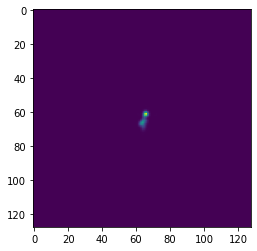

In [9]:
# 4. Rastgele Bir İndex Belirleyip Görselleştirelim..
index = 2000
plt.imshow(data['image'][index,:,:])
print('Ship class: ' + str(data['label'][index]))

Etiketlenmiş eğitim verilerini incelemenin son adımında, "image" öğesini girdi ("X") ve "label" öğesini çıktı ('y') değişkenleri olarak tanımlayabilirsiniz.

In [10]:
# 5. Verileri Girdi-Çıktı Şeklinde Ayarlayalim..
X = data['image']
y = data['label']

### VGG16 Modeliyle İlgili İşlemler..

Burada yapacağımız adım, ağ için bir giriş noktası olarak kullanılan bir Keras Tensörünü başlatmaktır. Python'un Tensorflow Keras API **tf.keras'ından Layer.Input** sınıfını kullanabiliriz. Tanımlayacağımız bu tensörün boyutu modeli eğitmek için kullanılan görüntülerin boyutlarıyla ilgilidir. 

In [11]:
# 6. Resimlere Göre Şekillendirme.
inputs = tf.keras.layers.Input(shape=(128, 128, 1))
inputs

<tf.Tensor 'input_1:0' shape=(None, 128, 128, 1) dtype=float32>

Artık VGG16 modelini somutlaştırabiliriz. Tensorflow Keras API, **tensorflow.keras.applications altında** önceden eğitilmiş ağırlıklara sahip bir dizi model (hazır mimariler) sunar ve VGG16 bunlardan biridir. Aşağıdaki anahtar sözcük bağımsız değişkenleriyle bir VGG16 modelini başlatabilirsiniz:

* **include_top =**False : Ağın tepesine tam olarak bağlı üç katmanı dahil etmek istemiyoruz diyoruz bu kodla.
* **weights=None** : Agırlıkları yok olarak ayarlayarak rastgele başlatmayı seçiyoruz.
* **input_tensor=inputs** : Giriş tensörü, önceki adımda oluşturulan giriş tensörüdür.
* **pooling='avg'** : Son evrişim bloğunun çıktısına genel ortalama havuzlama uygulanacaktır ve bu, modelin çıktısının iki boyutlu bir tensör olacağı anlamına gelir.

**NOT!..**

**Fully Connected Layers** : Varsayılan olarak algoritma üstte tam olarak bağlı üç katman içerecektir. 

**Pooling** : Havuzlama, CNN'lerde çok yaygın bir işlemdir ve muhtemelen en cok tartısılan da işlemdir. Havuzlama, kare bir bilgi bloğunun yalnızca min, maks veya ortalamasını alarak bilgileri azaltır / yoğunlaştırır.

Şimdi aşağıda VGG16 Modeliyle alakali bir kod yazalim...

In [12]:
# 7. VGG16 Kuruyoruz..
vgg = VGG16(include_top=False,
            weights=None,
            input_tensor=inputs,
            pooling='avg')

vgg

Örneklenmiş vgg modelimizden, girdi katmanı nesnesini fonksiyon girdisi ile alabiliriz. Ortaya çıkan nesne, modelin giriş tensörlerinden oluşan bir tensördür.

In [13]:
# 8. Fonksiyon alma İşlemi..
inp = vgg.input
inp

<tf.Tensor 'input_1:0' shape=(None, 128, 128, 1) dtype=float32>

Bir sonraki adımda, **VGG16 mimarisine benzemek için ağın tepesine tam bağlantılı üç katman ekliyoruz.** Prosedür, üç yoğun katman tanımlamak ve aralarına dropout/bırakma  katmanları eklemektir. Dropout/bırakma katmanları, düzenleme amacıyla ve fazla öğrenmeyi önlemek için tanıtılır. Prosedür bir yığınlama işlemine benzer - bu, önce yoğun bir katman, ardından bir dropout/bırakma  katmanı ve ardından yoğun bir katman oluşturacağınız anlamına gelir.

*tf.keras.layers.Dense() işleviyle yoğun bir katman ve tf.keras.layers.Dropout() işleviyle bir bırakma katmanı oluşturabiliriz.*

In [14]:
# 9 Katmanları Oluşturalim..

dense1 = tf.keras.layers.Dense(512, activation='relu')(vgg.output)
dropout1 = tf.keras.layers.Dropout(0.5)(dense1)

dense2 = tf.keras.layers.Dense(128, activation='relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.5)(dense2)

pred = tf.keras.layers.Dense(3, activation='softmax')(dropout2)
pred

<tf.Tensor 'dense_2/Softmax:0' shape=(None, 3) dtype=float32>

Yukarıda ki kodun yorumlanması..

* **dense1 :** vgg modelinin çıktısı'nın üzerine 512 nöronlu bir yoğun katman olusturduk ve **activation** işlevi olarak Relu kullanılmıştır. 


* **dropout1 :** Dense1 yoğun katmanının üstüne 512,128 (128 resim boyutundan geliyor.) baglantılarının yarınısı (0.5) rastgele atlayan bir bırakma katmanı ekliyoruz. 


* **dense2 :** Bırakma katmanı 'dropout1' üzerine 128 nöronlu başka bir 'yoğun katman' oluşturuyoruz ve aktivasyon işlevi olarak yeniden 'relu' (Rektifiye Edilmiş Doğrusal Birim) kullanıyoruz.

* **dropout2 :** Dense2 yogun katmanının üstüne bağlantılarının yarısını rastgele atlayan bir bırakma katmanı ekliyoruz.

* **pred :** Dropout2 bırakma katmanı üzerine 3 nöronlu son yogun katmanı olusturduk ve softmax etkinleştirme işlevini kullandık. Son nöron sayısı bildigimiz gibi tahmin edilecek sınıfların sayısını ifade etmektedir.

### Girdi ve Çıktıdan Keras Modeli Örneği Oluşturma

Yukarıdaki işlemlerle birlikte VGG16 modelimizi somutlaştırdık ve üstüne tam olarak bağlı üç katman olusturduk. Bunlar *dense1, dense2 ve pred katmanları.* Şimdi **tf.keras.Model()** içine **inp, pred** parametrelerini vererek modelimizi oluşturalim. Peki buradaki **inp ve pred** parametreleri nelerdir? 

* **inp :** Fonksiyon olarak işlemleri aldığımız yer. 
* **pred :**  Oluşturulan tahmin katmanı..

Yapacağımız bu işlev, katmanları eğitim ve çıktı özellikleriyle bir nesnede gruplandırır. Sonuç bir sonraki adımda eğitim için yapılandırabileceğimiz eğitimsiz bir sinir ağı olacaktır. 

In [16]:
# 10 Model Oluşturalim..
model = tf.keras.Model(inp, pred)

# 11. Model Özetini Görmek İstersek..
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)      

### Eğitim için Keras Modelini Yapılandırma 

Bu adımda eğitimsiz sinir ağı modelimizi yapılandırmaktır. Bunu yaparken **model.compile()** işleviyle modelimize çeşitli parametreler verebiliriz. Bu parametreler **loss, optimizers ve metrics** gibi parametrelerdir. 

In [17]:
# 12 Modeli Yapılandırma İşlemlerini Yapalim..
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True, name='SGD')
model.compile(optimizer=opt,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model

### Verilerden Eğitim ve Test Alt Kümelerini Oluşturma

In [18]:
# 13
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=42)

Şimdi oluşturduğumuz eğitim ve test verisinin boyutlarını kontrol edelim. Test verisinin boyutunu 0.25 yapmamız toplam elemanın (n=2805) 0.25'i dir. Yani bu örnekte, 701.25 gibi bir sayı olmali. Bunu bilgisayar bir üst sayıya veya bir alt sayıya yuvarlayabilir. 

In [19]:
# 14 Boyutlarını Öğrenelim.. 
print("X_train'in Boyutu...:",X_train.shape)
print("X_test'in Boyutu...:",X_test.shape)

X_train'in Boyutu...: (2103, 128, 128)
X_test'in Boyutu...: (702, 128, 128)


### Etiketlerin One-Hot Encoder İşlemi.. 

One-Hot Encoder, Makine Öğrenimi için kategorik özellikleri ön işlemenin yaygın bir yoludur. Etiketler özelliklere göre 0,1,2,.. diye rakamlar alarak sınıf numaraları temsil edilir. Verimizde yer alan gemi türlerini **tf.keras.utils.to_categorical()** işleviyle gemi sınıflarını temsile dönüştürebiliriz. Burada sırasıyla y_train ve y_test alt kümesi için etiketleri dönüştürmemiz gerekecek.

In [22]:
# 15.. 
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

### İsteğe Bağlı Aşama!.

Modeli eğitmeden önce gerekli callbacks tanımlamak en iyisidir. Eğitim sürecinin çeşitli aşamalarını analiz edebilmek için **model.fit()** gibi Keras yöntemlerine callbacks eklenebilir.

Bu aşamada işlemler yapabilmek için öncelikle modelimizi kayıt edelim..

In [28]:
# 16 Modeli Kayıt Etmek İstersek; 
model.save('C:\\Users\\ernsb\\Desktop\\AIFOR\\okyanusVerisi\\vgg.h5')

In [29]:
# 17. CallBacks Tanımlama İşlemi..
check = tf.keras.callbacks.ModelCheckpoint('C:\\Users\\ernsb\\Desktop\\AIFOR\\okyanusVerisi\\vgg.h5',
                                           monitor='val_accuracy',
                                           verbose=0,
                                           save_best_only=True, mode='auto')

Şimdi her dönemin sonuçlarını tf.keras.callbacks.CSVLogger() ile bir csv dosyasına kaydeden bir callbacks tanımlayalim..

In [34]:
# 18..
log = tf.keras.callbacks.CSVLogger('C:\\Users\\ernsb\\Desktop\\AIFOR\\okyanusVerisi\\vgg.txt')

In [35]:
# 19 Modeli Artık Oluşturalim.

import multiprocessing
from timeit import default_timer as timer

start = timer()
cpu_count = multiprocessing.cpu_count()
print(f"cpu: {cpu_count} found")

model.fit(X_train, y_train,
          batch_size=12,
          epochs=2,
#          epochs=150,
          verbose=1,
          validation_data=(X_test, y_test),
          steps_per_epoch = 25,
          max_queue_size=10,
          workers=cpu_count,
          use_multiprocessing=cpu_count > 1,
          callbacks=[check, log])

end = timer()
print('Elapsed time: ' + str(end - start))

cpu: 8 found
Epoch 1/2
25/25 [==============================] - 85s 3s/step - loss: 1.0957 - accuracy: 0.4367 - val_loss: 1.0947 - val_accuracy: 0.4017
Epoch 2/2
25/25 [==============================] - 102s 4s/step - loss: 1.0878 - accuracy: 0.4333 - val_loss: 1.0903 - val_accuracy: 0.4017
Elapsed time: 193.5309230999992


In [36]:
# 20 Eğitilmiş Modeli Yüklemek ve Değerlendirmek
# Modeli Yüklemek İstersek..

# model = load_model('Modelin Adresini Yaz Buraya..')

_, test_acc = model.evaluate(X_test, y_test)

print('Test_acc: %.4f' % test_acc)

22/22 [==============================] - 30s 1s/step - loss: 1.0903 - accuracy: 0.4017
Test_acc: 0.4017


Şimdi bu adımda eğitilmiş modelin yardımıyla bir gemi sınıfını tahmin etmek için **model.predict()** fonksiyonunu uygulayacağız. İşleve, test veri kümesinden ('X_test') bir girdi dizisi sağlarsak sonuç, her gemi sınıfı için olasılığı gösteren bir olasılık vektörüdür. En yüksek olasılık tahmin edilen sınıftır. Eğitilmiş modelin sağlamlığını daha iyi hissetmek için dizini değiştirmekten çekinmeyin.

Öyleyse başlayalim..

In [42]:
# 21..
class_names =['Bulk Carrier', 'Container Ship', 'Tanker'] # Verimiz de ki Gemi Türleri Bunlar..

index = 70  # Tahmin Etmek İstediğimiz Ürün No..
pred = model.predict(np.array([X_test[index]]))
print(pred)

[[0.36920962 0.30653554 0.3242548 ]]


In [43]:
# Tahmin Edilen ile Gerçek Veriyi Yazdırırsak..
print('Class to predict: ' + class_names[np.argmax(y_test[index])])
print('Predicted with label: ' +class_names[np.argmax(pred)])


Class to predict: Bulk Carrier
Predicted with label: Bulk Carrier
